In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt 
import auto_encoder
import math
import bisect
import pickle
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def seed(num_samples):
    pts = []
    i = 0
    it1 = int(math.sqrt(num_samples)/10)
    it2 = int((num_samples/10) - math.sqrt(num_samples))
    for j in range (10):
        for k in range(10):
            pts.append(i)
            i+=it1
        i+=it2
    return pts

In [3]:
def seq_to_magnetization(arr_seq, num_qubits):
    
    mag_vec = []
    for elem in arr_seq:
        magnetization = 0
        for char in elem:
            temp = (int(char)*-2)+1
            magnetization += temp 
        mag_vec.append(magnetization)
    mag_vec = np.array(mag_vec)
    mag_vec = mag_vec / (num_qubits)
    return mag_vec   

def seq_gen(num_q):
    if num_q == 2:
        return ['00','01', '10','11']
    else:
        temp = []
        
        smaller_vals = seq_gen(num_q-1)
        for i in ['0','1']:
            for each in smaller_vals:
                temp.append(i+each)
        return temp 

In [4]:
def error_points(mag, mag_t, num):
    diffs = abs((mag+1) - (mag_t+1))/(mag_t+1)
    points = (-np.asarray(diffs)).argsort()[:num]
    return points

In [5]:
def print_points(data1, qubits, error_points):    
    data = np.load(data1)
    Bx = data['fields'].T[qubits]
    Bz = data['fields'].T[2*qubits]
    points = []
    for i in error_points:
        points.append((Bx[i],Bz[i]))
    print(points)

In [6]:
def expand_pool(old_pool, error_points, max_pool_size):
    for i in error_points:
        num = int(i)
        if(i not in old_pool):
            bisect.insort(old_pool,i)
        else:
            Bz_low_num = num-1
            Bz_high_num= num+1
            Bz_low_flag=True
            Bz_high_flag=True
            
            Bx_low_num = int(num-math.sqrt(max_pool_size))
            Bx_high_num= int(num+math.sqrt(max_pool_size))
            Bx_low_flag=True
            Bx_high_flag=True
            
            while(Bz_low_flag or Bz_high_flag or Bx_low_flag or Bx_high_flag):
                if(Bz_low_flag):
                    if(Bz_low_num<=0 or Bz_low_num % math.sqrt(max_pool_size)==math.sqrt(max_pool_size)-1):
                        Bz_low_flag=False
                    elif(Bz_low_num not in old_pool):
                        bisect.insort(old_pool,Bz_low_num)
                        Bz_low_flag=False
                    else:
                        Bz_low_num-=1
                if(Bz_high_flag):
                    if(Bz_high_num>=max_pool_size or Bz_high_num % math.sqrt(max_pool_size)==0):
                        Bz_high_flag=False
                    elif(Bz_high_num not in old_pool):
                        bisect.insort(old_pool, Bz_high_num)
                        Bz_high_flag=False
                    else:
                        Bz_high_num+=1
                if(Bx_low_flag):
                    if(Bx_low_num<=0):
                        Bx_low_flag=False
                    elif(Bx_low_num not in old_pool):
                        bisect.insort(old_pool, Bx_low_num)
                        Bx_low_flag=False
                    else:
                        Bx_low_num-=int(math.sqrt(max_pool_size))
                if(Bx_high_flag):
                    if(Bx_high_num>=max_pool_size or Bx_high_num % math.sqrt(max_pool_size)==0):
                        Bx_high_flag=False
                    elif(Bx_high_num not in old_pool):
                        bisect.insort(old_pool, Bx_high_num)
                        Bx_high_flag=False
                    else:
                        Bx_high_num+=int(math.sqrt(max_pool_size))    
                    
    return old_pool

In [7]:
get_dataset = auto_encoder.get_dataset
data_2 = '2_qubit_crit_data.npz'
data_4 = '4_qubit_crit_data.npz'
data_6 = '6_qubit_crit_data.npz'
data_7 = '7_qubit_crit_data.npz'
data_8 = '8_qubit_crit_data.npz'
data_9 = '9_qubit_crit_data.npz'

training_n_sizes = [2,4,7]
validation_n_sizes = [6,8,9]

pts = seed(1600)

stop = 7

final_warmup_loss = [[0]*3 for i in range(stop)]
final_training_epoch_loss = [[0]*3 for i in range(stop)]
final_training_loss = [[0]*3 for i in range(stop)]
final_validation_loss = [[0]*6 for i in range(stop)]

magnetization_6 = []

In [8]:
for learning_set in range (stop):

    training_data_2 = auto_encoder.get_dataset_active(data_2,2,1600, pts)
    training_data_4 = auto_encoder.get_dataset_active(data_4,4,1600, pts)
    training_data_7 = auto_encoder.get_dataset_active(data_7,7,1600, pts) 


    split1 = int(len(pts)*0.9)
    split2 = int(len(pts)/10)
    split1 += len(pts)-(split1+split2)
    
    training_data_2, val_data_2 = random_split(training_data_2, [split1,split2])
    training_data_4, val_data_4 = random_split(training_data_4, [split1,split2])
    training_data_7, val_data_7 = random_split(training_data_7, [split1,split2])

    datasets = [training_data_2,
                training_data_4,
                training_data_7]

    training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=20) for x in datasets]

    val_data_6 = get_dataset(data_6, 6, 1600)
    val_data_8 = get_dataset(data_8, 8, 1600)
    val_data_9 = get_dataset(data_9, 9, 1600)

    val_datasets = [val_data_6, val_data_8, val_data_9, val_data_2, val_data_4, val_data_7]

    val_loaders = [DataLoader(x, batch_size = 10, num_workers=20) for x in val_datasets]

    warmup_2 = next(iter(training_loaders[0]))
    warmup_4 = next(iter(training_loaders[1]))
    warmup_7 = next(iter(training_loaders[2]))

    mps_size = 5
    model = auto_encoder.MPS_autoencoder(mps_size = mps_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_func = nn.MSELoss(reduction='sum')

    warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]

    print("WARMUP TRAINING ITERATION: ", learning_set)
    for j in range(10):
        for i in range(3):
            for epoch in range(10):
                fields,wf = warmup_data[i][0]
                gs = model(fields, warmup_data[i][1])            
                loss = loss_func(gs, wf)
                if (epoch % 10 == 0):
                    current_loss = loss.item() *(2**warmup_data[i][1])
                    print(warmup_data[i][1],"\t", current_loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if(j==9):
                final_warmup_loss[learning_set][i] = current_loss
    print("__________________________________________________")
    print()

    print("TRAINING ITERATION: ", learning_set)
    for j in range(10):
        print("Cycle: \t", j)
        print("*"*40)
        for i in range(3):
            for epoch in range(201):
                fields,wf = warmup_data[i][0]
                gs = model(fields, warmup_data[i][1])            
                loss = loss_func(gs, wf)
                if (epoch % 100 == 0):
                    current_loss = loss.item() *(2**warmup_data[i][1])
                    print(warmup_data[i][1],"\t", current_loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if(j==9):
                final_training_epoch_loss[learning_set][i] = current_loss
    print("__________________________________________________")
    print()


    warmup_2 = next(iter(training_loaders[0]))
    warmup_4 = next(iter(training_loaders[1]))
    warmup_7 = next(iter(training_loaders[2]))
    warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]

    print("TRAINING LOSS ITERATION: ", learning_set)
    for j in range(10):
        for i in range(3):
            for epoch in range(10):
                fields,wf = warmup_data[i][0]
                gs = model(fields, warmup_data[i][1])            
                loss = loss_func(gs, wf)
                if (epoch % 10 == 0):
                    current_loss = loss.item() *(2**warmup_data[i][1])
                    print(warmup_data[i][1],"\t", current_loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if(j==9):
                final_training_loss[learning_set][i] = current_loss        
    print("__________________________________________________")
    print()

    warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]
    f = open("warmup_data_2.p", 'wb')
    pickle.dump(warmup_data, f)
    f.close()

    f = open("warmup_data_1.p", 'wb')
    pickle.dump(warmup_data, f)
    f.close()

    val_6 = next(iter(val_loaders[0]))
    val_8 = next(iter(val_loaders[1]))
    val_9 = next(iter(val_loaders[2]))
    val_2 = next(iter(val_loaders[3]))
    val_4 = next(iter(val_loaders[4]))
    val_7 = next(iter(val_loaders[5]))

    print("VALIDATION LOSS ITERATION: ", learning_set)

    val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
    loss_func = nn.MSELoss()
    count=0
    for data, size in val_data:
        with torch.no_grad():
            fields, wf = data
            gs = model(fields, size)
            loss = loss_func(gs,wf)
            current = loss.item() * (2**size)
            print(size,"\t" ,current)
            final_validation_loss[learning_set][count] = current
        count+=1

    print("__________________________________________________")
    print()

    f = open("test_data_1.p", 'wb')
    pickle.dump(val_data, f)

    device = torch.device("cpu")
    for N, train_loader in enumerate(training_loaders):            
        temp = 0
        sys_size = training_n_sizes[N]
        for i, (fields,wf) in enumerate(train_loader):
            fields = fields.to(device)
            gs = model(fields, sys_size)            
            loss = loss_func(gs, wf.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            temp += loss.item()
        temp = temp / (len(train_loader)) 

    data_sizes = [2,4,6,7,8,9]
    training_data_2 = get_dataset(data_2, 2, 1600)
    training_data_4 = get_dataset(data_4,4,1600)
    training_data_7 = get_dataset(data_7,7,1600) 
    val_data_6 = get_dataset(data_6, 6, 1600)
    val_data_8 = get_dataset(data_8, 8, 1600)
    val_data_9 = get_dataset(data_9, 9, 1600)
    mag_dat = [training_data_2,training_data_4,val_data_6,training_data_7, val_data_8, val_data_9]
    mag_loaders = [DataLoader(x, batch_size = len(val_data_6), num_workers=20) for x in mag_dat]

    model.eval()
    with torch.no_grad():
        n_systems = {}
        for j,loader in enumerate((mag_loaders)):
            sys_size = data_sizes[j]
            wave_functions = []
            true_wave = []
            for i, (fields,wf) in enumerate(loader):
                fields = fields
                gs = model(fields, sys_size)

                wave_functions.append(gs)
                true_wave.append(wf)

            n_systems[sys_size] = (wave_functions,true_wave)


#     data_y_2 = n_systems[2][0][0].numpy()
#     data_y_4 = n_systems[4][0][0].numpy()
#     data_y_7 = n_systems[7][0][0].numpy()
    data_y_6 = n_systems[6][0][0].numpy()
#     data_y_8 = n_systems[8][0][0].numpy()
#     data_y_9 = n_systems[9][0][0].numpy()


    #     print(data_y_2.shape)
#     data_y_2_t = n_systems[2][1][0].numpy()
#     data_y_4_t = n_systems[4][1][0].numpy()
#     data_y_7_t = n_systems[7][1][0].numpy()
    data_y_6_t = n_systems[6][1][0].numpy()
#     data_y_8_t = n_systems[8][1][0].numpy()
#     data_y_9_t = n_systems[9][1][0].numpy()

#     vec = seq_to_magnetization(seq_gen(2),2)
#     vec_2 = (vec.view()).reshape((4,1))
#     mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
#     mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

#     vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
#     mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
#     mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))

    vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
    mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
    mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))
    
    magnetization_6.append(mag_6)

#     vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
#     mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
#     mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

#     vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
#     mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
#     mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

#     vec_9 = seq_to_magnetization(seq_gen(9),9).reshape((512,1))
#     mag_9 = np.squeeze((np.power(data_y_9,2) @ vec_9))
#     mag_9_t = np.squeeze((np.power(data_y_9_t,2) @ vec_9))

    error_pts = error_points(mag_6, mag_6_t, 10)
    print("ERROR POINTS:")
    print_points(data_6, 6, error_pts)


    pts = expand_pool(pts, error_pts, 1600)
    print("NEW SET: ")
    print(pts)
    print()
    print("_________________________________")


/home/jszacha1/.conda/envs/conda_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


WARMUP TRAINING ITERATION:  0
2 	 95.83270263671875
4 	 357.58892822265625
7 	 14966.2158203125
2 	 29.65999412536621
4 	 1026.034423828125
7 	 12694.76171875
2 	 20.9695987701416
4 	 284.5081787109375
7 	 10709.6875
2 	 11.650313377380371
4 	 317.1753845214844
7 	 7386.17822265625
2 	 13.341142654418945
4 	 406.57379150390625
7 	 2410.91015625
2 	 10.32675838470459
4 	 90.8653564453125
7 	 1470.8328857421875
2 	 9.942071914672852
4 	 75.10659790039062
7 	 1174.3271484375
2 	 10.071375846862793
4 	 79.30810546875
7 	 895.2179565429688
2 	 8.33958625793457
4 	 79.35087585449219
7 	 1025.238525390625
2 	 6.369146347045898
4 	 59.66160583496094
7 	 937.751953125
__________________________________________________

TRAINING ITERATION:  0
Cycle: 	 0
****************************************
2 	 6.17912483215332
2 	 3.236358165740967
2 	 2.3078529834747314
4 	 49.96955108642578
4 	 38.18193817138672
4 	 15.80082893371582
7 	 819.4718017578125
7 	 427.198974609375
7 	 272.94952392578125
Cycle: 

In [9]:
qubit_nums = [2,4,7]

print("Final Warmup Loss:")
for i in range (3):
    print(qubit_nums[i], ":")
    for j in range (stop):
        print("set", j,":", final_warmup_loss[j][i])
        
print()
print("Final Training Epoch Loss:")
for i in range (3):
    print(qubit_nums[i], ":")
    for j in range (stop):
        print("set", j,":", final_training_epoch_loss[j][i])        

print()
print("Final Training Loss:")
for i in range (3):
    print(qubit_nums[i], ":")
    for j in range (stop):
        print("set", j,":", final_training_loss[j][i]) 
        
qubit_nums = [6,8,9,2,4,7]
print()
print("Final Validation Loss:")
for i in range (6):
    print(qubit_nums[i], ":")
    for j in range (stop):
        print("set", j,":", final_validation_loss[j][i]) 

Final Warmup Loss:
2 :
set 0 : 6.369146347045898
set 1 : 6.929922580718994
set 2 : 4.711767673492432
set 3 : 7.5705718994140625
set 4 : 4.926126003265381
set 5 : 7.3127851486206055
set 6 : 5.959205627441406
4 :
set 0 : 59.66160583496094
set 1 : 32.74504852294922
set 2 : 34.732521057128906
set 3 : 25.311363220214844
set 4 : 34.95937728881836
set 5 : 35.76649475097656
set 6 : 48.5150260925293
7 :
set 0 : 937.751953125
set 1 : 626.2342529296875
set 2 : 418.6545104980469
set 3 : 250.4417724609375
set 4 : 521.482177734375
set 5 : 590.4720458984375
set 6 : 347.2604064941406

Final Training Epoch Loss:
2 :
set 0 : 0.1476781666278839
set 1 : 0.4401274025440216
set 2 : 0.16979017853736877
set 3 : 0.18802279233932495
set 4 : 0.10604268312454224
set 5 : 0.2150828093290329
set 6 : 0.1298023909330368
4 :
set 0 : 0.7228692770004272
set 1 : 1.1025208234786987
set 2 : 1.0580155849456787
set 3 : 0.7967659831047058
set 4 : 0.7782357931137085
set 5 : 1.0491795539855957
set 6 : 4.559260368347168
7 :
set 0

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


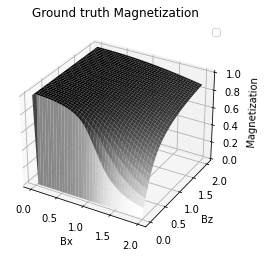

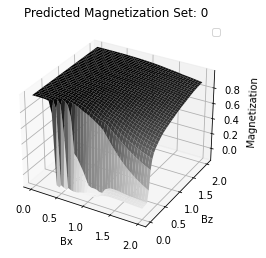

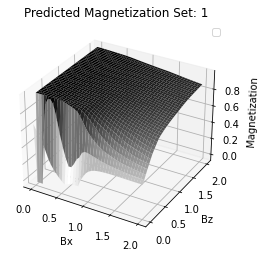

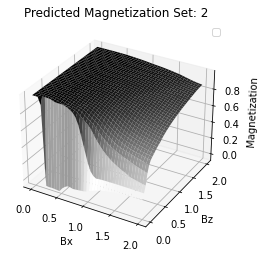

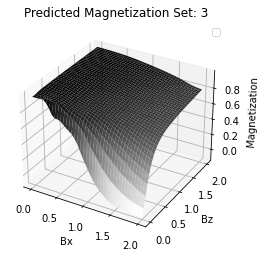

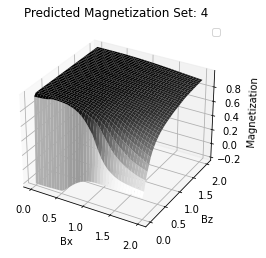

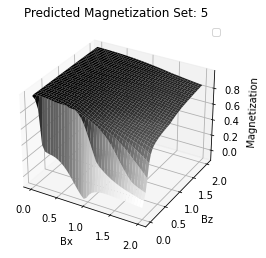

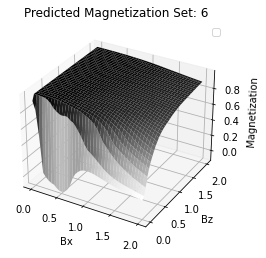

In [10]:
data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

x = np.reshape(Bx, (40, 40))
y = np.reshape(Bz, (40, 40))
z = np.reshape(mag_6_t, (40, 40))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

for i in range (stop):
    z = np.reshape(magnetization_6[i], (40, 40))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization Set: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bx")
    ax.set_ylabel("Bz")
    ax.set_zlabel("Magnetization")

    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


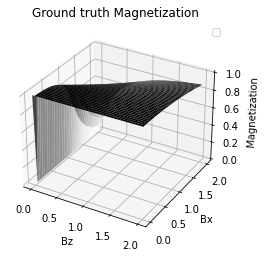

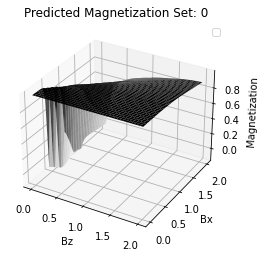

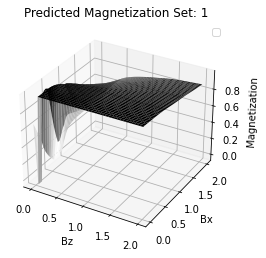

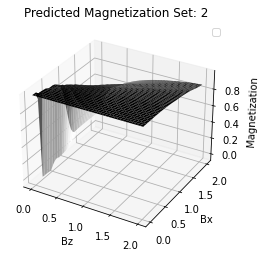

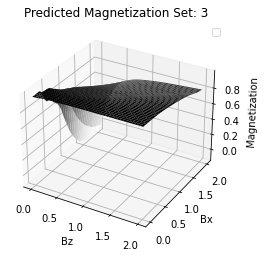

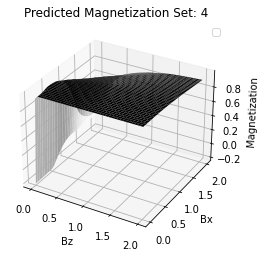

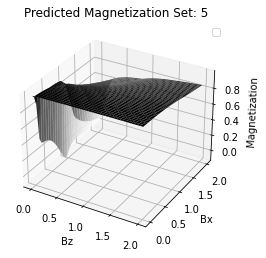

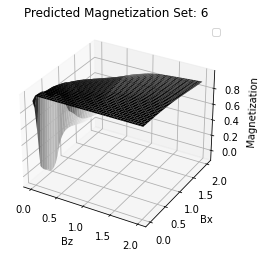

In [11]:
y = np.reshape(Bx, (40, 40))
x = np.reshape(Bz, (40, 40))
z = np.reshape(mag_6_t, (40, 40))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization")
ax.set_xlabel("Bz")
ax.set_ylabel("Bx")
ax.set_zlabel("Magnetization")

for i in range (stop):
    z = np.reshape(magnetization_6[i], (40, 40))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization Set: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bz")
    ax.set_ylabel("Bx")
    ax.set_zlabel("Magnetization")

In [77]:
print(len(pts2))
training_data_2 = auto_encoder.get_dataset_active(data_2,2,1600, pts2)
training_data_4 = auto_encoder.get_dataset_active(data_4,4,1600, pts2)
training_data_7 = auto_encoder.get_dataset_active(data_7,7,1600, pts2) 

training_data_2, val_data_2 = random_split(training_data_2, [100,10])
training_data_4, val_data_4 = random_split(training_data_4, [100,10])
training_data_7, val_data_7 = random_split(training_data_7, [100,10])

datasets = [training_data_2,
            training_data_4,
            training_data_7]

training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=20) for x in datasets]

val_datasets = [val_data_6, val_data_8, val_data_9, val_data_2, val_data_4, val_data_7]

val_loaders = [DataLoader(x, batch_size = 10, num_workers=20) for x in val_datasets]

    
        
    
        


110


In [ ]:
warmup_2 = next(iter(training_loaders[0]))
warmup_4 = next(iter(training_loaders[1]))
warmup_7 = next(iter(training_loaders[2]))

In [78]:
mps_size = 5
model = auto_encoder.MPS_autoencoder(mps_size = mps_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss(reduction='sum')

warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]

for j in range(10):
    for i in range(3):
        for epoch in range(10):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            if (epoch % 10 == 0):
                print(warmup_data[i][1],"\t", loss.item() *(2**warmup_data[i][1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

2 	 180.05601501464844
4 	 396.9764709472656
7 	 10215.5751953125
2 	 18.95096206665039
4 	 89.82289123535156
7 	 1120.547119140625
2 	 9.390539169311523
4 	 114.86370849609375
7 	 665.7327270507812
2 	 9.205703735351562
4 	 27.10988998413086
7 	 541.2842407226562
2 	 6.068642616271973
4 	 31.623220443725586
7 	 602.8790283203125
2 	 3.5196595191955566
4 	 32.66358947753906
7 	 555.59814453125
2 	 5.390881538391113
4 	 32.55101776123047
7 	 357.78985595703125
2 	 5.217724800109863
4 	 24.43670082092285
7 	 423.5292663574219
2 	 2.31003475189209
4 	 17.998199462890625
7 	 398.8067932128906
2 	 3.052884101867676
4 	 25.578933715820312
7 	 532.6058349609375


In [79]:
for j in range(10):
    print("Cycle: \t", j)
    print("*"*40)
    for i in range(3):
        for epoch in range(201):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            if (epoch % 100 == 0):
                print(warmup_data[i][1],"\t", loss.item()*(2**warmup_data[i][1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

Cycle: 	 0
****************************************
2 	 2.7821240425109863
2 	 0.8656794428825378
2 	 1.0361649990081787
4 	 10.10662841796875
4 	 6.433604717254639
4 	 9.843862533569336
7 	 314.19775390625
7 	 178.2550506591797
7 	 129.41354370117188
Cycle: 	 1
****************************************
2 	 1.6743013858795166
2 	 0.5070786476135254
2 	 0.5475218296051025
4 	 5.278177261352539
4 	 1.4191985130310059
4 	 2.4135565757751465
7 	 166.12510681152344
7 	 126.17274475097656
7 	 114.77327728271484
Cycle: 	 2
****************************************
2 	 1.3151390552520752
2 	 0.4743051528930664
2 	 0.2869024872779846
4 	 3.0823166370391846
4 	 2.003108263015747
4 	 6.410835266113281
7 	 159.98497009277344
7 	 152.13739013671875
7 	 107.46759033203125
Cycle: 	 3
****************************************
2 	 0.7299072742462158
2 	 0.1635984480381012
2 	 0.23090417683124542
4 	 3.750051975250244
4 	 1.2644503116607666
4 	 1.6398191452026367
7 	 150.90695190429688
7 	 107.522987365722

In [80]:
warmup_2 = next(iter(training_loaders[0]))
warmup_4 = next(iter(training_loaders[1]))
warmup_7 = next(iter(training_loaders[2]))
warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]


for j in range(10):
    for i in range(3):
        for epoch in range(10):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            if (epoch % 10 == 0):
                print(warmup_data[i][1],"\t", loss.item() *(2**warmup_data[i][1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

2 	 3.7701163291931152
4 	 23.84670639038086
7 	 270.21173095703125
2 	 3.244191884994507
4 	 11.059944152832031
7 	 211.09796142578125
2 	 1.608811378479004
4 	 8.963644027709961
7 	 148.74935913085938
2 	 0.7763664126396179
4 	 6.531449317932129
7 	 167.21124267578125
2 	 1.0262962579727173
4 	 2.948197603225708
7 	 222.29953002929688
2 	 0.8547028303146362
4 	 6.0203752517700195
7 	 113.70122528076172
2 	 0.8155598640441895
4 	 2.4043195247650146
7 	 213.64430236816406
2 	 1.0712642669677734
4 	 9.077162742614746
7 	 167.03335571289062
2 	 0.9819191098213196
4 	 7.032845497131348
7 	 166.7865753173828
2 	 0.6856197118759155
4 	 2.5456082820892334
7 	 124.79643249511719


In [81]:
import pickle
warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]
f = open("warmup_data_2.p", 'wb')
pickle.dump(warmup_data, f)
f.close()

In [82]:
f = open("warmup_data_1.p", 'wb')
pickle.dump(warmup_data, f)
f.close()

In [83]:
val_6 = next(iter(val_loaders[0]))
val_8 = next(iter(val_loaders[1]))
val_9 = next(iter(val_loaders[2]))
val_2 = next(iter(val_loaders[3]))
val_4 = next(iter(val_loaders[4]))
val_7 = next(iter(val_loaders[5]))


In [84]:
val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
loss_func = nn.MSELoss()
for data, size in val_data:
    with torch.no_grad():
        fields, wf = data
        gs = model(fields, size)
        loss = loss_func(gs,wf)
        print(size,"\t" ,loss.item() * (2**size))

6 	 0.07589209824800491
8 	 0.026231374591588974
9 	 0.033223532140254974
2 	 0.003109519137069583
4 	 0.055870283395051956
7 	 0.0051779476925730705


In [85]:
f = open("test_data_1.p", 'wb')
pickle.dump(val_data, f)

In [86]:
device = torch.device("cpu")
for N, train_loader in enumerate(training_loaders):            
    temp = 0
    sys_size = training_n_sizes[N]
    for i, (fields,wf) in enumerate(train_loader):
        fields = fields.to(device)
        gs = model(fields, sys_size)            
        loss = loss_func(gs, wf.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp += loss.item()
    temp = temp / (len(train_loader)) 

In [87]:
model.eval()
with torch.no_grad():
    n_systems = {}
    for j,loader in enumerate((mag_loaders)):
        sys_size = data_sizes[j]
        wave_functions = []
        true_wave = []
        for i, (fields,wf) in enumerate(loader):
            fields = fields
            gs = model(fields, sys_size)

            wave_functions.append(gs)
            true_wave.append(wf)

        n_systems[sys_size] = (wave_functions,true_wave)


data_y_2 = n_systems[2][0][0].numpy()
data_y_4 = n_systems[4][0][0].numpy()
data_y_7 = n_systems[7][0][0].numpy()
data_y_6 = n_systems[6][0][0].numpy()
data_y_8 = n_systems[8][0][0].numpy()
data_y_9 = n_systems[9][0][0].numpy()


#     print(data_y_2.shape)
data_y_2_t = n_systems[2][1][0].numpy()
data_y_4_t = n_systems[4][1][0].numpy()
data_y_7_t = n_systems[7][1][0].numpy()
data_y_6_t = n_systems[6][1][0].numpy()
data_y_8_t = n_systems[8][1][0].numpy()
data_y_9_t = n_systems[9][1][0].numpy()

vec = seq_to_magnetization(seq_gen(2),2)
vec_2 = (vec.view()).reshape((4,1))
mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))

vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))

vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

vec_9 = seq_to_magnetization(seq_gen(9),9).reshape((512,1))
mag_9 = np.squeeze((np.power(data_y_9,2) @ vec_9))
mag_9_t = np.squeeze((np.power(data_y_9_t,2) @ vec_9))

In [96]:
error_pts = error_points(mag_6, mag_6_t, 10)
print(error_pts)

qubits=6
data = np.load(data_6)
Bx = data['fields'].T[qubits]
Bz = data['fields'].T[2*qubits]
points = []
print(len(Bx))
for i in error_pts:
    points.append((Bx[i],Bz[i]))
print(points)
# print(pts2)   
# pts3 = expand_pool(pts2, error_pts, 1600)
# print(pts3)

[561 521 601 481 641 441 681 401 361 721]
1600
[(0.717948717948718, 0.05128205128205128), (0.6666666666666666, 0.05128205128205128), (0.7692307692307692, 0.05128205128205128), (0.6153846153846154, 0.05128205128205128), (0.8205128205128205, 0.05128205128205128), (0.5641025641025641, 0.05128205128205128), (0.8717948717948718, 0.05128205128205128), (0.5128205128205128, 0.05128205128205128), (0.4615384615384615, 0.05128205128205128), (0.923076923076923, 0.05128205128205128)]


In [89]:
print(len(pts3))
training_data_2 = auto_encoder.get_dataset_active(data_2,2,1600, pts3)
training_data_4 = auto_encoder.get_dataset_active(data_4,4,1600, pts3)
training_data_7 = auto_encoder.get_dataset_active(data_7,7,1600, pts3) 

training_data_2, val_data_2 = random_split(training_data_2, [110,10])
training_data_4, val_data_4 = random_split(training_data_4, [110,10])
training_data_7, val_data_7 = random_split(training_data_7, [110,10])

datasets = [training_data_2,
            training_data_4,
            training_data_7]

training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=20) for x in datasets]

val_datasets = [val_data_6, val_data_8, val_data_9, val_data_2, val_data_4, val_data_7]

val_loaders = [DataLoader(x, batch_size = 10, num_workers=20) for x in val_datasets]

120


ValueError: Sum of input lengths does not equal the length of the input dataset!

In [3]:
t = [[0]*3 for i in range(5)]
t[0][1]=1
print(t)

[[0, 1, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
